In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

sublist = pd.read_csv('/media/garlicseed/data2/Schizophrenia/Morphometrics/subjList.txt').values.flatten()

# Initialize lists to store individual metrics
SA_matrix = []
GV_matrix = []
thick_avg_matrix = []
thick_std_matrix = []
mean_curv_matrix = []
gaus_curv_matrix = []

mopho_matrix = []

for sub in tqdm_notebook(sublist):
    lh_data = pd.read_csv(f"/media/garlicseed/data2/Schizophrenia/Morphometrics/{sub}_lh_schaefer400_stats.txt", sep=r'\s+', comment='#', header=None,
                          names=["StructName", "NumVert", "SurfArea", "GrayVol", "ThickAvg","ThickStd","MeanCurv", "GausCurv","FoldInd", "CurvInd"])
    rh_data = pd.read_csv(f"/media/garlicseed/data2/Schizophrenia/Morphometrics/{sub}_rh_schaefer400_stats.txt", sep=r'\s+', comment='#', header=None,
                          names=["StructName", "NumVert", "SurfArea", "GrayVol", "ThickAvg","ThickStd","MeanCurv", "GausCurv","FoldInd", "CurvInd"])

    lh_data = lh_data.iloc[1:].reset_index(drop=True)
    rh_data = rh_data.iloc[1:].reset_index(drop=True)
    combined_data = pd.concat([lh_data, rh_data], axis=0).reset_index(drop=True)
    schaefer_400_label = combined_data['StructName']
    combined_data = combined_data.drop(['NumVert', 'FoldInd', 'CurvInd', 'StructName'], axis=1)
    
    # Flatten individual columns and append to respective lists
    SA_matrix.append(combined_data['SurfArea'].values.flatten())
    GV_matrix.append(combined_data['GrayVol'].values.flatten())
    thick_avg_matrix.append(combined_data['ThickAvg'].values.flatten())
    thick_std_matrix.append(combined_data['ThickStd'].values.flatten())
    mean_curv_matrix.append(combined_data['MeanCurv'].values.flatten())
    gaus_curv_matrix.append(combined_data['GausCurv'].values.flatten())
    
    # Concatenate all flattened arrays into a single array
    final_array = np.concatenate((combined_data['SurfArea'].values.flatten(), combined_data['GrayVol'].values.flatten(), 
                                  combined_data['ThickAvg'].values.flatten(), combined_data['ThickStd'].values.flatten(), 
                                  combined_data['MeanCurv'].values.flatten(), combined_data['GausCurv'].values.flatten()))
    mopho_matrix.append(final_array)

# Stack all individual metric lists into arrays
SA_stack = np.stack(SA_matrix, axis=0)
GV_stack = np.stack(GV_matrix, axis=0)
thick_avg_stack = np.stack(thick_avg_matrix, axis=0)
thick_std_stack = np.stack(thick_std_matrix, axis=0)
mean_curv_stack = np.stack(mean_curv_matrix, axis=0)
gaus_curv_stack = np.stack(gaus_curv_matrix, axis=0)
mopho_stack = np.stack(mopho_matrix, axis=0)

# Save each stack as a CSV file (paths need to be specified)
pd.DataFrame(SA_stack).to_csv('/media/garlicseed/data2/Schizophrenia/Morphometrics/combine_data/SA_stack.csv', index=False)
pd.DataFrame(GV_stack).to_csv('/media/garlicseed/data2/Schizophrenia/Morphometrics/combine_data/GV_stack.csv', index=False)
pd.DataFrame(thick_avg_stack).to_csv('/media/garlicseed/data2/Schizophrenia/Morphometrics/combine_data/thick_avg_stack.csv', index=False)
pd.DataFrame(thick_std_stack).to_csv('/media/garlicseed/data2/Schizophrenia/Morphometrics/combine_data/thick_std_stack.csv', index=False)
pd.DataFrame(mean_curv_stack).to_csv('/media/garlicseed/data2/Schizophrenia/Morphometrics/combine_data/mean_curv_stack.csv', index=False)
pd.DataFrame(gaus_curv_stack).to_csv('/media/garlicseed/data2/Schizophrenia/Morphometrics/combine_data/gaus_curv_stack.csv', index=False)
pd.DataFrame(mopho_stack).to_csv('/media/garlicseed/data2/Schizophrenia/Morphometrics/combine_data/mopho_stack.csv', index=False)
pd.DataFrame(schaefer_400_label).to_csv('/media/garlicseed/data2/Schizophrenia/Morphometrics/combine_data/schaefer_400_label.csv', index=False)

/tmp/ipykernel_91162/1384729994.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sub in tqdm_notebook(sublist):


  0%|          | 0/90 [00:00<?, ?it/s]

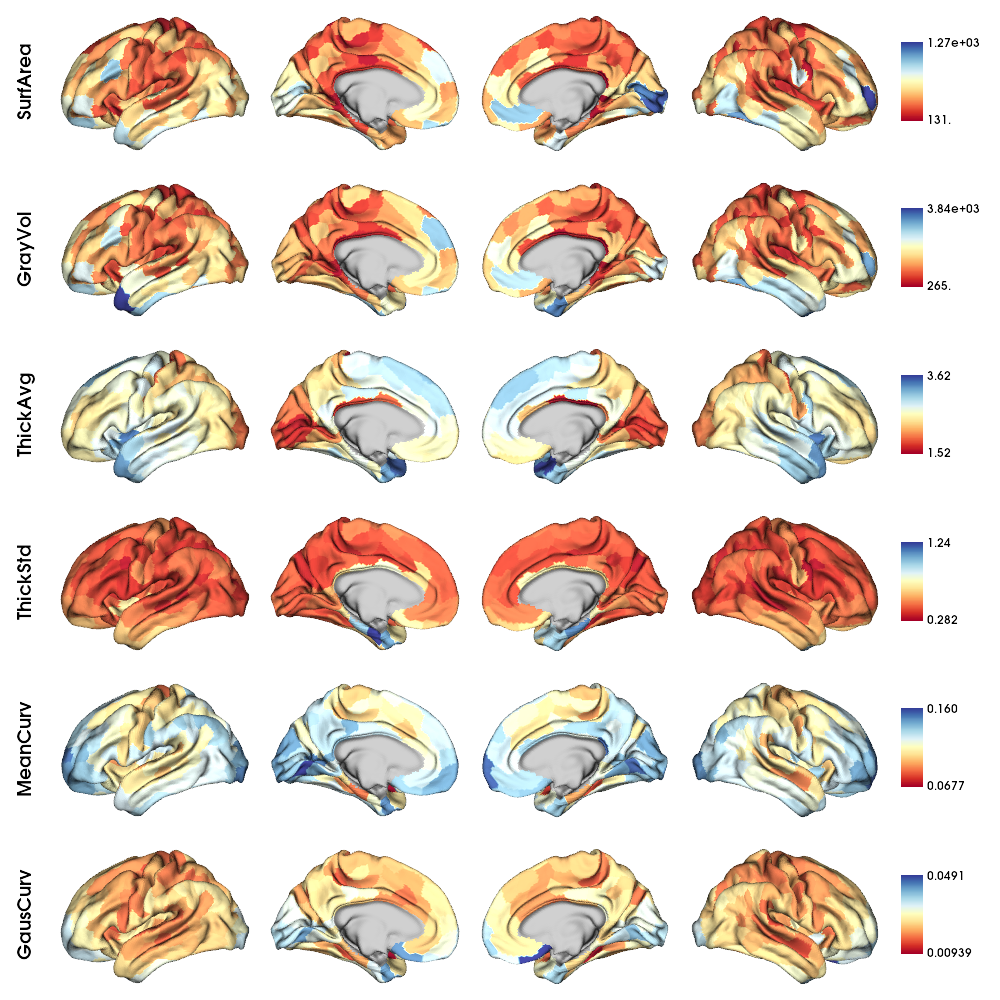

In [3]:
from brainspace.mesh.mesh_io import read_surface
subj_dir = '/media/garlicseed/data2/Schizophrenia/derivate/micapipe_v0.2.0/'
atlas='schaefer-400' 
micapipe='/media/garlicseed/data2/Schizophrenia' # <<<<<<<<<<<< CHANGE THIS PATH
# Load fsLR-32k
f32k_lh = read_surface(f'{micapipe}/surfaces/fsLR-32k.L.surf.gii', itype='gii')
f32k_rh = read_surface(f'{micapipe}/surfaces/fsLR-32k.R.surf.gii', itype='gii')
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainspace.datasets import load_parcellation
pial_left, pial_right = fetch_template_surface("fsaverage5", join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
mask = fetch_mask("fsaverage5")
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels

labeling = load_parcellation('schaefer', scale=400, join=True)
mask = labeling != 0
mophos = [SA_stack, GV_stack, thick_avg_stack, thick_std_stack, mean_curv_stack, gaus_curv_stack]
label_text = ['SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv']
mapp = [None] * len(mophos)

for i, k in enumerate(mophos):
    mean_values = np.mean(k, axis=0)
    mapp[i] = map_to_labels(mean_values, labeling, mask=mask, fill=np.nan)

plot_hemispheres(f32k_lh, f32k_rh, mapp, color_bar=True,
        label_text=label_text, cmap="RdYlBu", embed_nb=True, size=(1000, 1000), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False, layout_style = 'row')

In [14]:
mapp

array([396.4       , 299.37777778, 329.5       , ..., 626.53333333,
       626.53333333, 626.53333333])